In [1]:
! pip install pymorphy2

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 11.8 MB/s 


In [2]:
import nltk

import numpy as np
import pandas as pd
import math

from collections import Counter

import pymorphy2

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import nltk

import pandas as pd

import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

import nltk

import pandas as pd

import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Настало время решить классическую, для практически любого типа данных, задачу - классификацировать наши тексты!

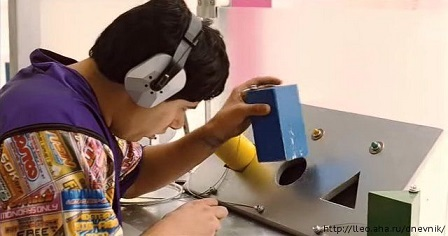



---

Классическим методом классификации текстов является "Наивный байесовский классификатор"




---


**Формула Байесовского классификатора:**

Довольно красивая, формула из, довольно красивой, [статьи](https://habr.com/ru/post/415963/).

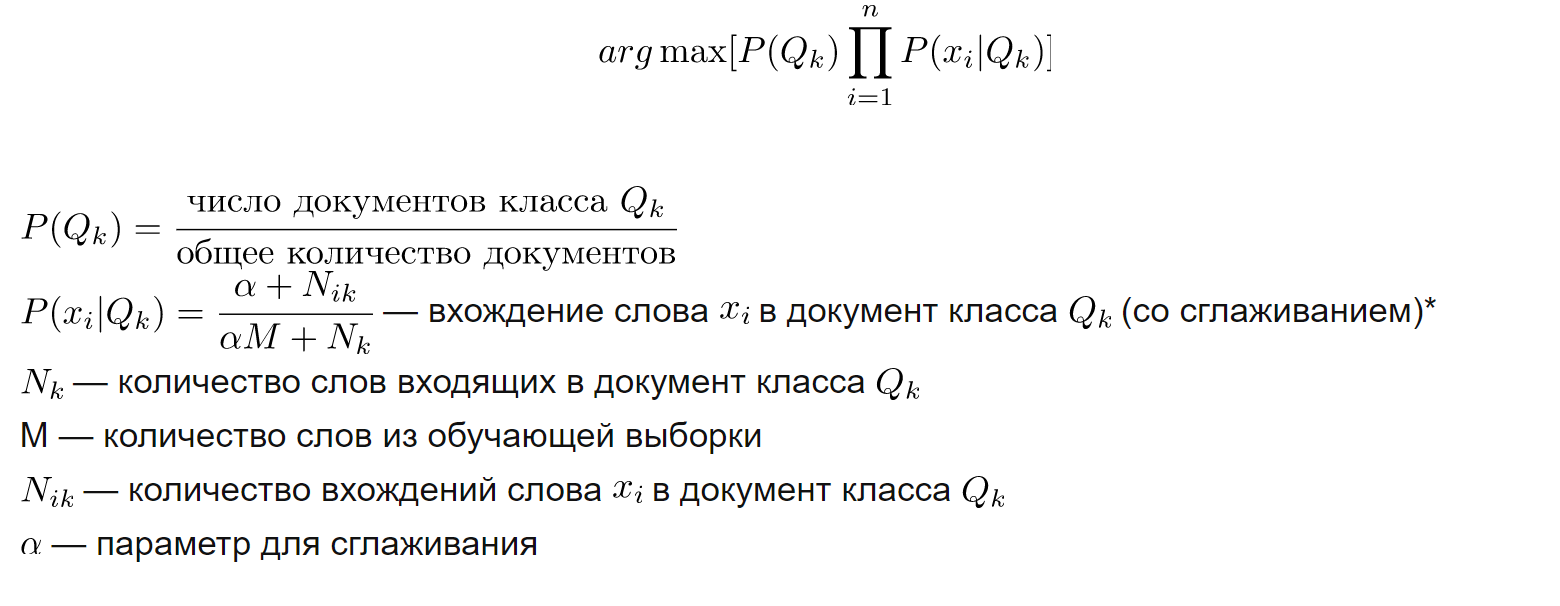

Для того, чтобы ускорить процесс, воспользуемся частью датасета (уже предобработан и очищен от редко встречающихся токенов)

In [ ]:
data_train = pd.read_csv("Word2Vec_Classification_train.csv")
data_test = pd.read_csv("Word2Vec_Classification_test.csv")

Загрузим, знакомый нам, словарь, в котором нет редких токенов.

In [6]:
vocabulary = []
with open('vocabulary_Word2Vec.txt', 'r') as f:
    for item in f:
        vocabulary.append(item[:-1])

Далее получаем необходимые данные

separated - упорядоченные данные (понадобится в будующем)

doc_counts - кол-во документов каждого класса

In [7]:
classes = set(data_train.loc[:,"class"])
separated = [[row for index, row in data_train.iterrows() if row["class"] == pop] for pop in classes]
doc_counts = {i[0]["class"]:len(i) for i in separated}

In [8]:
words = np.array([vocabulary for i in classes])
words = words.reshape(words.shape[0]*words.shape[1])
df = pd.DataFrame({"words":words}) 

Далее получаем датафрейм с количеством каждого слова в каждом документе.


---


Или можно просто его загрузить)


```
data_train = pd.read_csv("naive_bayes_helper.csv")
```



In [9]:
df_classes = np.array([[cls for word in vocabulary] for cls in classes])
df_classes = df_classes.reshape(df_classes.shape[0]*df_classes.shape[1])
df['class'] = df_classes

In [10]:
df['count'] = np.zeros(df_classes.shape)

for sep in separated:
  for row in sep:
    counts = Counter(nltk.word_tokenize(row["text"]))
    for word in counts:
      df.loc[(df['words'] == word) & (df['class'] == row["class"]), 'count'] += counts[word]

In [11]:
print(df)

             words     class  count
0       катастрофы  politics    3.0
1         самолета  politics    6.0
2      следователи  politics    3.0
3          главное  politics    1.0
4       управление  politics    1.0
...            ...       ...    ...
46062      тихенко   science    0.0
46063        пасху   science    0.0
46064           чо   science    0.0
46065         ммкф   science    0.0
46066    ипотечных   science    0.0

[46067 rows x 3 columns]


Общее кол-во слов в каждом классе

In [ ]:
words_in_classes = {cls:0 for cls in classes}

In [ ]:
N = len(data_train)
for i in range(N):
    cur = data_train.loc[i,"text"]
    for x in nltk.word_tokenize(cur):
      if x in vocabulary:
        words_in_classes[data_train.loc[i,"class"]]+=1

train_words = sum(words_in_classes.values())

In [ ]:
print(words_in_classes)

{'religion': 6233, 'politics': 5294, 'world': 4631, 'society': 7668, 'culture': 9238, 'science': 5539, 'economy': 10431}


Теперь, на основе произведенных подсчетов, можно сделать предсказание на тестовых данных.

In [ ]:
accuracy = 0

result = []

for index, row in data_test.iterrows():
  print(index)
  predict = {cls:math.log(doc_counts[cls]/N) for cls in classes}
  example = row["text"]
  x = nltk.word_tokenize(example)
  for cls in classes:
      for word in x:
          if word in vocabulary:
              predict[cls] += math.log((1+int(df.loc[(df['words'] == word) & (df['class'] == cls), 'count'])) / ( train_words + words_in_classes[cls] ))
  result.append([max(predict, key=predict.get),row["class"]])

In [ ]:
for i in result:
  if i[0] == i[1]:
    accuracy+=1

print("Accuracy: ", accuracy/len(data_test))

Accuracy:  0.5171428571428571


**Word2Vec классификация.**

Итак, классификация на основе Word2Vec.

Для этого нужно загрузить полученные эмбединги в качестве первого слоя, а после обучить второй - на классификацию.

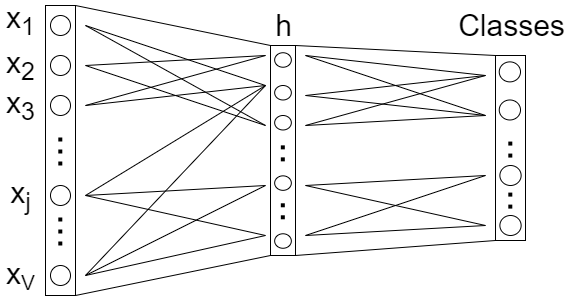

Загружаем датасеты и словарь.

In [ ]:
data = pd.read_csv("Word2Vec_Classification_train.csv")
data_test = pd.read_csv("Word2Vec_Classification_test.csv")

In [ ]:
vocabulary = []
with open('vocabulary_Word2Vec.txt', 'r') as f:
    for item in f:
        vocabulary.append(item[:-1])

print(vocabulary)

['катастрофы', 'самолета', 'следователи', 'главное', 'управление', 'следственного', 'комитета', 'рф', 'января', 'отчет', 'комиссии', 'ту', 'борту', 'которого', 'находился', 'президент', 'польши', 'говорится', 'сообщении', 'опубликованном', 'официальном', 'сайте', 'ск', 'предстоит', 'установить', 'лиц', 'подчеркивает', 'органы', 'другими', 'делу', 'необходимые', 'действия', 'кроме', 'пять', 'числе', 'запрос', 'прессконференции', 'руководителей', 'основным', 'эксперты', 'решение', 'экипажа', 'уходить', 'аэродром', 'несмотря', 'также', 'давление', 'которое', 'говорилось', 'ввс', 'впоследствии', 'нашли', 'произошла', 'апреля', 'года', 'помимо', 'самого', 'погибли', 'другие', 'члены', 'октябре', 'передал', 'стороне', 'проект', 'польша', 'россии', 'свои', 'примерно', 'сторона', 'часть', 'ответственности', 'будут', 'однако', 'минобрнауки', 'вдвое', 'федеральный', 'перечень', 'учебников', 'использования', 'российских', 'школах', 'раза', 'новый', 'список', 'заседании', 'февраля', 'совет', 'сооб

Индексируем слова и классы.

In [ ]:
word2idx = {word:idx for idx, word in enumerate(vocabulary)}

class2idx = {cls: idx for (idx, cls) in enumerate(data.loc[:,"class"])}
class2idx = {cls: idx for (idx, cls) in enumerate(class2idx)}
print(class2idx)

{'politics': 0, 'world': 1, 'religion': 2, 'science': 3, 'society': 4, 'culture': 5, 'economy': 6}


Функции, призванные составлять входные данные и таргеты в корректном виде.

In [ ]:
def get_input_layer(idx, df):
  res = torch.zeros(len(vocabulary)).float()
  words = nltk.word_tokenize(df.loc[idx,"text"])
  for word in words:
    if word in vocabulary:
      res[word2idx[word]] = 1.0
  return res

def get_target(idx, df):
  return class2idx[df.loc[idx,"class"]]

Непосредственно обучение ( и параллельное сравнение на тестовом датасете).

Заметьте что изменяется только второй слой.

In [ ]:
embedding_dims = 5 # размерность эмбединга
vocabulary_size = len(vocabulary)

num_epochs = 100 # кол-во эпох взято с запасом, так как сохранятся веса с самым лучшим результатом
learning_rate = 0.01

N = len(data)

W1 = torch.load("W1.pt")
W2 = Variable(torch.randn(7, embedding_dims).float(), requires_grad=True)

best_accuracy = 0

for epo in range(num_epochs):
    accuracy = 0
    loss_val = 0
    for idx in range(N):
        # Начало кода для предсказания
        x_valid = Variable(get_input_layer(idx, data_test)).float()
        y_true_valid = Variable(torch.from_numpy(np.array([get_target(idx, data_test)])).long())

        z1_valid = torch.matmul(W1, x_valid)
        z2_valid = torch.matmul(W2, z1_valid)

        pred = torch.argmax(torch.softmax(z2_valid, dim=-1))

        if pred == y_true_valid[0]:
          accuracy+=1 
        # Конец кода для предсказания 

        x = Variable(get_input_layer(idx, train_data)).float()
        y_true = Variable(torch.from_numpy(np.array([get_target(idx, train_data)])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item() 
        loss.backward()
        
        # Изменяем веса только второго слоя
        W2.data -= learning_rate * W2.grad.data

        W2.grad.data.zero_()
    print(f'Loss at epo {epo}: {loss_val/N}')
    print(f'Accuracy: {accuracy/N}')

    if accuracy/N > best_accuracy:
      best_accuracy = accuracy/N
      torch.save(W2, 'W2.pt')

print("best_accuracy = ", best_accuracy)